# Imports

In [607]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as date
from sklearn.preprocessing import OneHotEncoder

# Loading Data

## Loading personal data directly from the dataset

In [573]:
client_groups = ["0 ao 100", "101 ao 200", "201 ao 300", "301 ao 400", "401 ao 500"]

df = pd.DataFrame()


for group in client_groups:

    with open(
        "Cliente " +
        group +
        "/customers/01-personal-identification.json", "r") as read_file:
        
            data = json.loads(read_file.read())
            personalIdentification = pd.DataFrame(data)
            df = pd.concat([
                df,
                personalIdentification
            ], join='outer', axis=0)
            
df.set_index('customerId', inplace=True)

In [574]:
income = pd.DataFrame()
patrimony = pd.DataFrame()

for group in client_groups:

    with open(
        "Cliente " +
        group +
        "/customers/01-personal-qualification.json", "r") as read_file:

            data = json.loads(read_file.read())
            for customer in data:
                income_now = pd.DataFrame([customer['informedIncome']])
                income_now['customerId'] = customer['customerId']
                income = pd.concat([
                    income, income_now
                ], axis=0)
                patrimony_now = pd.DataFrame([customer['informedPatrimony']])
                patrimony_now['customerId'] = customer['customerId']
                patrimony = pd.concat([
                    patrimony, patrimony_now
                ], axis=0)

In [575]:
print(income["frequency"].describe())
print(50*'=')
print(income["currency"].describe())
print(50*'=')
print()
print(50*'=')
print(patrimony["year"].describe())
print(50*'=')
print(patrimony["currency"].describe())

count        500
unique         1
top       MENSAL
freq         500
Name: frequency, dtype: object
count     500
unique      1
top       BRL
freq      500
Name: currency, dtype: object

count     500.0
mean     2021.0
std         0.0
min      2021.0
25%      2021.0
50%      2021.0
75%      2021.0
max      2021.0
Name: year, dtype: float64
count     500
unique      1
top       BRL
freq      500
Name: currency, dtype: object


#### it's possible to see above that all the data is given in BRL and are from the year of 2021

#### the data above shows us that we don't need to care about different payment frequencies or currencies, since they are all equal

In [576]:
df = df.reindex(columns = df.columns.tolist() + ["creditCardLimit", "creditCardUsedAmount"])

for group in client_groups:

    with open(
        "Cliente " +
        group +
        "/credit-cards/03-credit-cards-limits.json", "r") as read_file:

            data = json.loads(read_file.read())
            for customer in data:
                # checks if all the customers have their data in BRL
                if customer['limitAmountCurrency'] != 'BRL' or customer['usedAmountCurrency'] != 'BRL':
                    print(str(customer['customerId']) + ' has his data not in BRL')

                # adds the data to the df
                df.loc[customer['customerId'], "creditCardLimit"] = customer['limitAmount']
                df.loc[customer['customerId'], "creditCardUsedAmount"] = customer['usedAmount']

In [577]:
df = df.reindex(columns = df.columns.tolist() + ["transactionsAmount"], fill_value=0)

for group in client_groups:

    with open(
        "Cliente " +
        group +
        "/accounts/04-accounts-transactions.json", "r") as read_file:

            data = json.loads(read_file.read())
            for transaction in data:
                # checks if all transactions were made in BRL
                if transaction["transactionCurrency"] != 'BRL':
                    print(str(transaction['transactionId']) + ' is not in BRL!')

                # adds the data to the df
                df.loc[transaction['customerId'], "transactionsAmount"] += transaction['amount']

49018
51291
52730
52554
53308


In [578]:
df = df.reindex(columns = df.columns.tolist() + ["mensalIncome", "patrimony"])

income.set_index('customerId', inplace=True)
patrimony.set_index('customerId', inplace=True)
for c_id in list(df.index):

    df.loc[str(c_id), "mensalIncome"] = income.loc[str(c_id), "amount"]
    df.loc[c_id, "patrimony"] = patrimony.loc[c_id, "amount"]

In [585]:
# remove unimportant columns

importantColumns = [
    'maritalStatusCode',
    'birthDate',
    'customerId',
    'mensalIncome',
    'patrimony',
    'creditCardLimit',
    'creditCardUsedAmount',
    'transactionsAmount'
]

df = df.drop(
    [col for col in list(df.columns) if col not in importantColumns] , axis=1
)

# Data clensing and metrics generator

In [589]:
# check existing NULL
df[df.isnull().any(axis=1)]

,birthDate,maritalStatusCode,creditCardLimit,creditCardUsedAmount,transactionsAmount,mensalIncome,patrimony
customerId,,,,,,,


In [590]:
print(df.loc[:, 'birthDate'].describe())
df = df.drop(['birthDate'], axis=1)

count            500
unique             1
top       2021-05-21
freq             500
Name: birthDate, dtype: object


#### The `birthDate` column gives us no relevant information about the client, since all clients where born at the same daym. So we droped this column. However the `maritalStatusCode` column can give us some useful information

In [591]:
print(df.loc[:, 'maritalStatusCode'].describe())
print(50*'=')
print(df.loc[:, 'maritalStatusCode'].unique())

count        500
unique         7
top       CASADO
freq          84
Name: maritalStatusCode, dtype: object
['CASADO' 'DIVORCIADO' 'SOLTEIRO' 'UNIAO_ESTAVEL' 'SEPARADO_JUDICIALMENTE'
 'VIUVO' 'OUTRO']


## Data frame of our analysis:

In [592]:
df.head()

,maritalStatusCode,creditCardLimit,creditCardUsedAmount,transactionsAmount,mensalIncome,patrimony
customerId,,,,,,
595.080.896-84,CASADO,14446.89,8490.13,662743.20,4894.45,29653.89
412.289.303-97,DIVORCIADO,9460.85,6641.37,1306678.54,5249.96,5374.31
785.797.738-73,SOLTEIRO,17122.05,11424.37,528652.11,2979.59,39383.10
331.154.515-63,CASADO,8884.47,8303.85,216145.74,19643.32,3260.11
114.795.138-29,UNIAO_ESTAVEL,2078.23,1441.76,73505.81,7812.45,42733.14


# Data Analysis

<AxesSubplot:>

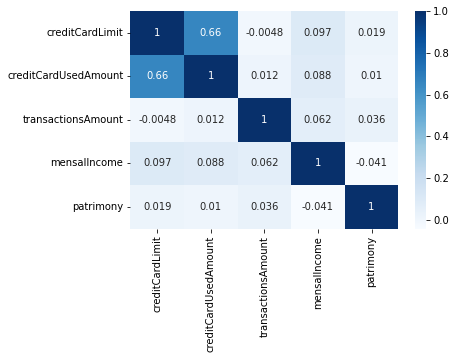

In [593]:
corr = df.corr()
sns.heatmap(corr, cmap="Blues", annot=True)

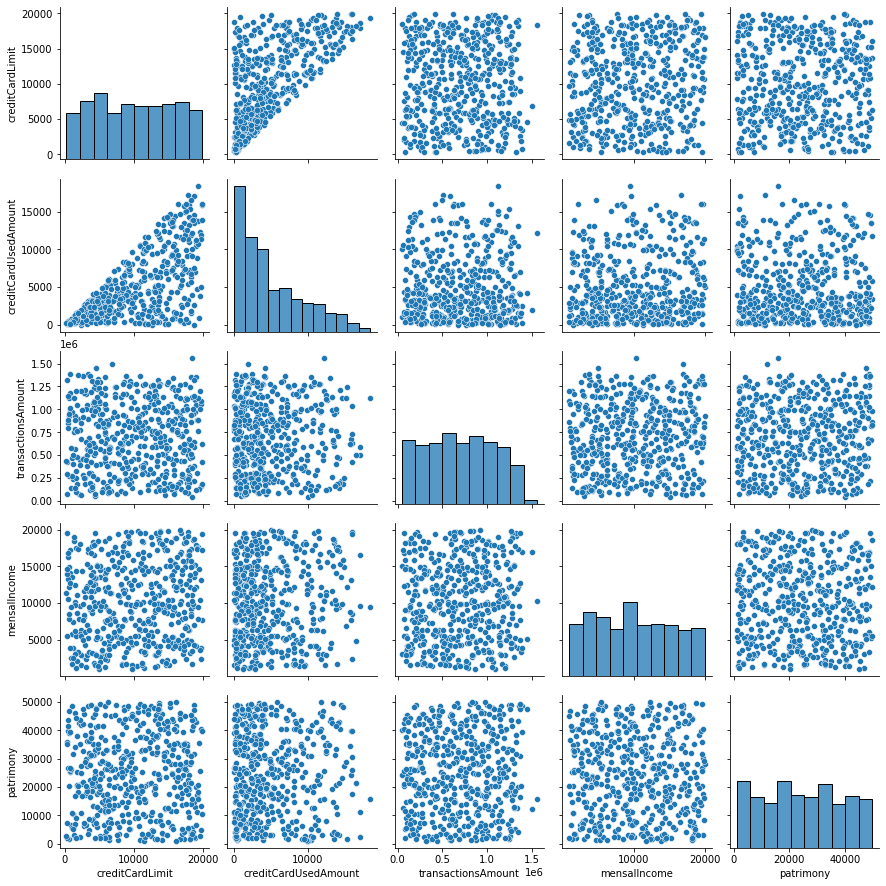

In [594]:
sns.pairplot(df)

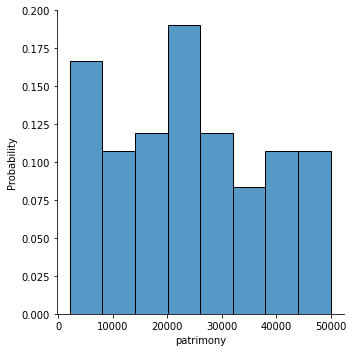

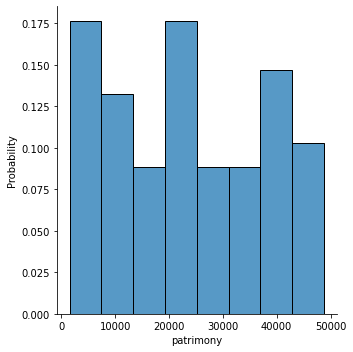

In [605]:
for code in ['CASADO', 'SOLTEIRO']:
    sns.displot(df.loc[lambda x: x['maritalStatusCode'] == code],
                x="patrimony",
                stat='probability')

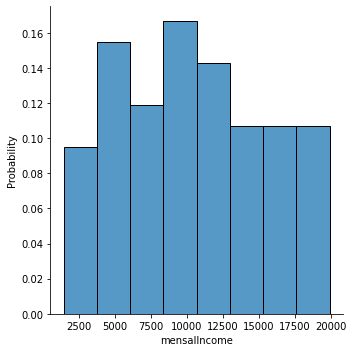

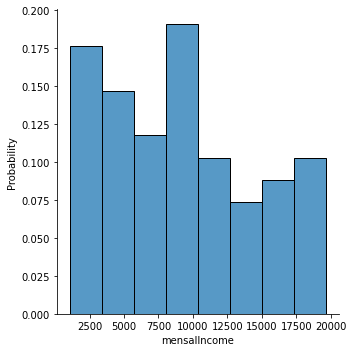

In [606]:
for code in ['CASADO', 'SOLTEIRO']:
    sns.displot(df.loc[lambda x: x['maritalStatusCode'] == code],
                x="mensalIncome",
                stat='probability')

# Conclusão

#### A partir dos dados relevantes usados na construção do nosso data frame, realizamos dois plots para comparar a relação entre as variáveis, e assim, conseguir insights sobre os perfis de clientes que existem. Os dois plots mensionados são a matriz de correlação e o pairplot.
#### Não foi possível encontrar padrões nos dados que correspondam a uma conta de banco normal, ou seja, os dados não representam a realidade. Isso se torna claro pelos seguintes fatores:

- Uma correlação (corr=0.088, i.e. correlação negligível) entre `mensalIncome` e `creditCardLimit` foi observada (o contrário seria o esperado). O mesmo comentado anteriormente acontece entre `mensalIncome` e `patrimony` (corr=-0.041) e entre `mensalIncome` e `transactionsAmount` (corr=0.062);
- A distribuição de `mensalIncome` e `patrimony` entre os diferentes estados civis não fazem sentido também, pois, por exemplo a probabilidade do patrimônio de alguém casado e de alguém solteiro somar mais de 50000 BRL é, de acordo com os dados, igualmente alta, mas isso não é o que geralmente se espera, pois pessoas casadas na média têm um patrimônio acumulado maior do que pessoas solteiras.

#### Caso os dados fornecidos fossem mais próximos da realidade, seria possível fazer uma análise profunda em que as nuances de cada perfil de cliente se fariam claras, por exemplo, o patrimônio de pessoas solteiras em comparação com o de pessoas casadas e quão líquida é a conta bancária de cada um deles. Essas informações seriam chave para a classificação de clientes em conservadores ou pessoas propensas a risco, dando uma base estatística para o BTG Delphos.